In [1]:
pip install unidecode

     |████████████████████████████████| 245kB 3.0MB/s 


In [46]:
import pandas as pd
import tweepy as tw
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import unidecode
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from nltk.stem import PorterStemmer
nltk.download('punkt')
from nltk.tokenize import word_tokenize 
import re
from collections import Counter
import plotly.express as px

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
consumer_key = 'Tan0zgQRjQxjyubOPCbERip1p'
consumer_secret = 'Rcjd0sID7brrcH682RVDFNjc8yxBuEHI6Kq5PQlhVPiskVi6ri'
access_token = '261123310-nhpBB26oASCDw2HdQA7Hoxui7f0jpMaPOr068b9W'
access_token_secret = 'gWQ41E4bfc4EalWnnWv147NeoCDkwo2cadKJFtIbTVy0z'

auth = tw.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tw.API(auth, wait_on_rate_limit=True)

In [4]:
dataset = pd.read_csv('/content/drive/My Drive/38891_59255/train_E6oV3lV.csv')

# Data cleaning

In [5]:
dataset.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [6]:
dataset.shape

(31962, 3)

### Cleaning for duplicates and null values

In [7]:
dataset.drop_duplicates(inplace=True)

In [8]:
dataset.shape #no duplicates exist

(31962, 3)

In [9]:
dataset['label'].isna().sum() #no null labels

0

In [10]:
dataset['tweet'].isna().sum() #no null tweets

0

### Removing mentions

In [11]:
dataset['clean_tweet'] = dataset['tweet'].apply(lambda x: ' '.join([tweet for tweet in x.split() if not tweet.startswith("@")]))

In [12]:
dataset.head()

,id,label,tweet,clean_tweet
0,1,0,@user when a father is dysfunctional and is s...,when a father is dysfunctional and is so selfi...
1,2,0,@user @user thanks for #lyft credit i can't us...,thanks for #lyft credit i can't use cause they...
2,3,0,bihday your majesty,bihday your majesty
3,4,0,#model i love u take with u all the time in ...,#model i love u take with u all the time in ur...
4,5,0,factsguide: society now #motivation,factsguide: society now #motivation


### Removing numbers

In [13]:
dataset['clean_tweet'] = dataset['clean_tweet'].apply(lambda x: ' '.join([tweet for tweet in x.split() if not tweet.isnumeric()]))

### Removing non english symbols


In [14]:
dataset['clean_tweet'] = dataset['clean_tweet'].apply(lambda x: ' '.join([unidecode.unidecode(tweet) for tweet in x.split()]))

### Correcting slang words

In [15]:
slang = {'luv':'love','wud':'would','lyk':'like','wateva':'whatever','ttyl':'talk to you later',
          'kul':'cool','fyn':'fine','omg':'oh my god!','fam':'family','bruh':'brother', 'cud':'could',
         'fud':'food', 'u':'you', 'ur':'your', 'frm': 'from'}

In [16]:
dataset['clean_tweet'] = dataset['clean_tweet'].apply(lambda x : ' '.join(slang[word] if word in slang else word for word in x.split()))

### Finding hashtags

In [17]:
dataset['Hashtags'] = dataset['clean_tweet'].apply(lambda x : ' '.join([word for word in x.split() if word.startswith('#')]))

In [18]:
dataset.head()

,id,label,tweet,clean_tweet,Hashtags
0,1,0,@user when a father is dysfunctional and is s...,when a father is dysfunctional and is so selfi...,#run
1,2,0,@user @user thanks for #lyft credit i can't us...,thanks for #lyft credit i can't use cause they...,#lyft #disapointed #getthanked
2,3,0,bihday your majesty,bihday your majesty,
3,4,0,#model i love u take with u all the time in ...,#model i love you take with you all the time i...,#model
4,5,0,factsguide: society now #motivation,factsguide: society now #motivation,#motivation


In [19]:
dataset['Hashtags'][dataset['Hashtags'] == ''] = 'No hashtags'

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [20]:
dataset.head()

,id,label,tweet,clean_tweet,Hashtags
0,1,0,@user when a father is dysfunctional and is s...,when a father is dysfunctional and is so selfi...,#run
1,2,0,@user @user thanks for #lyft credit i can't us...,thanks for #lyft credit i can't use cause they...,#lyft #disapointed #getthanked
2,3,0,bihday your majesty,bihday your majesty,No hashtags
3,4,0,#model i love u take with u all the time in ...,#model i love you take with you all the time i...,#model
4,5,0,factsguide: society now #motivation,factsguide: society now #motivation,#motivation


### Removing stopwords

In [21]:
dataset['clean_tweet'] = dataset['clean_tweet'].apply(lambda x : ' '.join([word for word in x.split() if not word in set(stopwords.words('english'))]))

### Lemmatization

In [25]:
lemmatizer = WordNetLemmatizer()
dataset['clean_tweet'] = dataset['clean_tweet'].apply(lambda x : ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))

### Stemming

In [26]:
ps = PorterStemmer()
dataset['clean_tweet'] = dataset['clean_tweet'].apply(lambda x : ' '.join([ps.stem(word) for word in x.split()]))

### Tokenization

In [27]:
corpus = []
for i in range(0,31962):
    tweet = dataset['clean_tweet'][i]
    tweet = tweet.lower()
    tweet = tweet.split()
    tweet = [ps.stem(word) for word in tweet if not word in set(stopwords.words('english'))]
    tweet = ' '.join(tweet)
    corpus.append(tweet)

In [28]:
len(corpus)

31962

### Collecting hashtags

In [32]:
def hashtag_extract(x):
    hashtags = []
    # Loop over the words in the tweet
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)

    return hashtags

In [33]:
hash_positive = hashtag_extract(dataset['clean_tweet'][dataset['label'] == 0])
hash_negative = hashtag_extract(dataset['clean_tweet'][dataset['label'] == 1])

In [34]:
hash_positive = sum(hash_positive,[])
hash_negative = sum(hash_negative,[])

In [37]:
q = Counter(hash_positive)
q = dict(q.most_common())
l_positive_count = list(q.values())
l_positive_values = list(q.keys())

In [38]:
r = Counter(hash_negative)
r = dict(r.most_common())
l_negative_count = list(r.values())
l_negative_values = list(r.keys())

In [43]:
# dataframe for count of most common negative and positive hashtags
l1 = pd.DataFrame(l_positive_values,columns = ['Positive #'])
l2 = pd.DataFrame(l_positive_count,columns = ['Positive # Count'])
l3 = pd.DataFrame(l_negative_values,columns = ['Negative #'])
l4 = pd.DataFrame(l_negative_count,columns = ['Negative # Count'])
hashtags_df = pd.concat([l1,l2,l3,l4],axis = 1)

In [45]:
hashtags_df

,Positive #,Positive # Count,Negative #,Negative # Count
0,love,1579,trump,133.0
1,posit,905,polit,94.0
2,smile,636,allahsoil,92.0
3,healthi,558,liber,79.0
4,thank,526,libtard,77.0
...,...,...,...,...
21899,ucsda,1,NaN,NaN
21900,berlincitygirl,1,NaN,NaN
21901,za,1,NaN,NaN
21902,genf,1,NaN,NaN


# Visualizations

### Wordcloud

In [29]:
negative = ' '.join(dataset[dataset['label'] == 1]['clean_tweet'])
positive = ' '.join(dataset[dataset['label'] == 0]['clean_tweet'])
wc = WordCloud(width = 800, height = 500, max_font_size = 110, max_words=100)

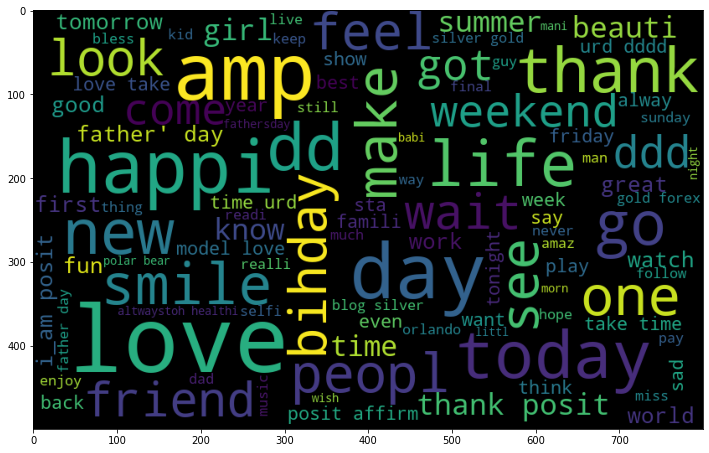

In [30]:
wc.generate(positive)
plt.figure(figsize=(12,8))
plt.imshow(wc)

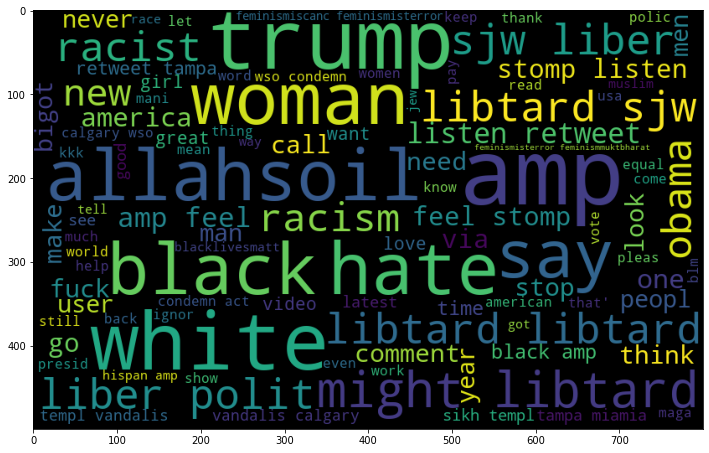

In [31]:
wc.generate(negative)
plt.figure(figsize=(12,8))
plt.imshow(wc)

### Hashtag Frequency

In [51]:
fig = px.bar(hashtags_df[:20], x="Positive #", y="Positive # Count", hover_name="Positive #")
fig.show()

In [52]:
fig = px.bar(hashtags_df[:20], x="Negative #", y="Negative # Count", hover_name="Negative #")
fig.show()